In [ ]:
%load_ext autoreload
%autoreload 2
from scapy.contrib.modbus import *
from scapy.contrib.stun import *
from scapy.layers.usb import *
from scapy_tools import get_packet_class_by_name, pkt2field_names_bytes, get_packet_instance_by_name

from scapy.all import *
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'text.latex.preamble': '\\usepackage[dvips]{graphicx}\\usepackage{xfrac}\\usepackage{amssymb}\\usepackage{lmodern}'
})

In [ ]:
STATIC_KEYS = ['ARP', 'ModBusTCP', 'UDP', 'PPPoED', 'EAPOL', 'SCTP', 'VRRP', 'NBNSHeader']
PARENTS = [Ether, TCP, IP, Ether, Ether, IP, IP, UDP]
valid_fields = ['StrField', 'Field', 'ByteField', 'ByteEnumField', 'StrLenField', 'FlagsField', 'StrFixedLenField', 'PadField', 
                    'SockAddrsField', 'LenField', 'EnumField', 'FieldLenField', 'MayEnd', 'XStrLenField', 'IP6Field', 'UUIDField', 'ShortField', 'XByteField', 'XShortField', 
                    'BitField', 'BitEnumField', 'MACField', 'FieldListField', 'XIntField', 'IntField', 'LongField', 'IntEnumField', 'SignedIntField', 
                    'XNBytesField', 'XBitField', 'ShortEnumField', 'XShortEnumField', 'SourceMACField', 'SourceIPField', 'IPField']

# Real Data Distribution

>>>>>>> ARP
Headers/ARP/CIC-DDoS2019/arp.pcap
NUM PKTS 134
here ['ARP'] <class 'scapy.layers.l2.Ether'> Ether / ARP who has 192.168.50.253 says 192.168.50.8 / Padding
first fields ['hwtype', 'ptype', 'hwlen', 'plen', 'op', 'hwsrc', 'psrc', 'hwdst', 'pdst']
NUM PARSED 134
Headers/ARP/brute_shark/ARP_brute_shark.pcap
NUM PKTS 622
here ['ARP'] <class 'scapy.layers.l2.Ether'> Ether / ARP who has 24.166.173.159 says 24.166.172.1 / Padding
first fields ['hwtype', 'ptype', 'hwlen', 'plen', 'op', 'hwsrc', 'psrc', 'hwdst', 'pdst']
NUM PARSED 622
Headers/ARP/smia/arp_smia.pcap
NUM PKTS 1024
here ['ARP'] <class 'scapy.layers.l2.Ether'> Ether / Dot1Q / ARP who has 172.19.2.27 says 172.19.2.1 / Padding
first fields ['hwtype', 'ptype', 'hwlen', 'plen', 'op', 'hwsrc', 'psrc', 'hwdst', 'pdst']
NUM PARSED 1024
Headers/ARP/pcap1/arp_1024.pcap
NUM PKTS 1024
here ['ARP'] <class 'scapy.layers.l2.Ether'> Ether / ARP who has 192.168.50.253 says 192.168.50.8 / Padding
first fields ['hwtype', 'ptype', 'hwlen',

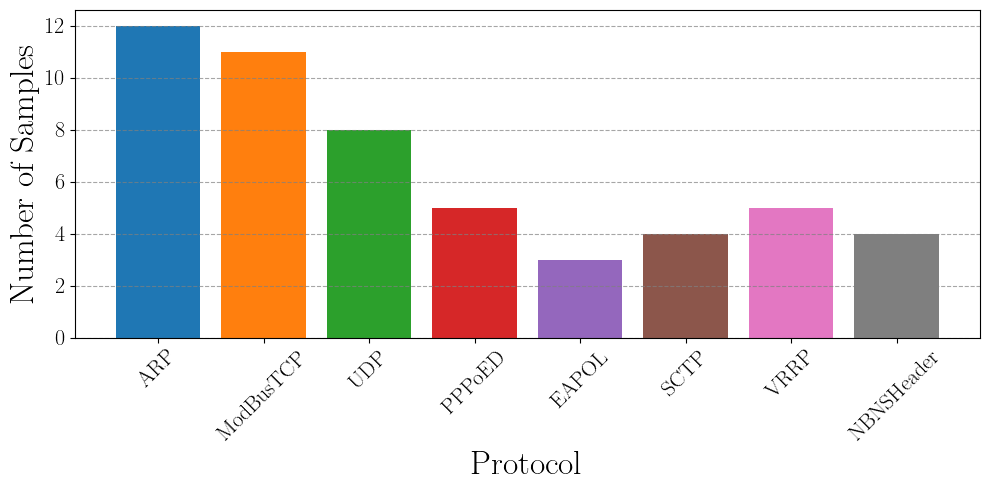

In [ ]:
from build_X_y import build_real_x_y, build_fake_x_y
from PacketDataset import PacketDataset
from torch.utils.data import Dataset, DataLoader
from Plotting import plot_protocol_distribution

XR, yR, psR = build_real_x_y(STATIC_KEYS, PARENTS)
dataset = PacketDataset(XR, yR, protocols=psR)
loader = DataLoader(dataset, batch_size=1, shuffle=False)
p_count_dict = {}
for _, _, p in loader:
    p = p[0]
    p_count_dict[p] = p_count_dict.get(p, 0) + 1

plot_protocol_distribution(loader)

In [ ]:
plot_protocol_distribution(loader)

# Build scapy fuzz version

In [ ]:
from build_X_y import build_real_x_y, build_fake_x_y
from itertools import combinations
Xf, yf, psf = build_fake_x_y(p_count_dict, STATIC_KEYS, PARENTS, generator='Scapy')
X = XR + Xf
y = yR + yf
ps = psR + psf

from train_model import train_model
all_models, all_losses, all_vals = [], [], []
for i, val in enumerate(list(combinations(STATIC_KEYS, 2))):
    print(f'ROUND {i}')
    model, losses, val_scores = train_model(X, y, ps, val=val)
    all_models.append(model)
    all_losses.append(losses)
    all_vals.append(val_scores)

In [ ]:
from Plotting import plot_all_runs
plot_all_runs(all_losses,'Training Loss', save='Plots/ScapyTrainingLoss.pdf')
plot_all_runs(all_vals, 'Validation Accuracy', save='Plots/ScapyValidationAccuracy.pdf')

# Build My Fuzz Version

In [ ]:
from build_X_y import build_real_x_y, build_fake_x_y
Xf, yf, psf = build_fake_x_y(p_count_dict, STATIC_KEYS, PARENTS, generator='Markov')
X = XR + Xf
y = yR + yf
ps = psR + psf

from train_model import train_model
all_models, all_losses, all_vals = [], [], []
for i, val in enumerate(list(combinations(STATIC_KEYS, 2))):
    print(f'ROUND {i}')
    model, losses, val_scores = train_model(X, y, ps, val=val)
    all_models.append(model)
    all_losses.append(losses)
    all_vals.append(val_scores)

from Plotting import plot_all_runs
plot_all_runs(all_losses,'Training Loss', save='Plots/MarkovTrainingLoss.pdf')
plot_all_runs(all_vals, 'Validation Accuracy', save='Plots/MarkovValidationAccuracy.pdf')

# CNN Generator

In [ ]:
from build_X_y import build_real_x_y, build_fake_x_y
Xf, yf, psf = build_fake_x_y(p_count_dict, STATIC_KEYS, PARENTS, generator='CNN', FIELD_TYPE_VOCAB=valid_fields)
X = XR + Xf
y = yR + yf
ps = psR + psf

from train_model import train_model
all_models, all_losses, all_vals = [], [], []
for i, val in enumerate(list(combinations(STATIC_KEYS, 2))):
    print(f'ROUND {i}')
    model, losses, val_scores = train_model(X, y, ps, val=val, plots=False)
    all_models.append(model)
    all_losses.append(losses)
    all_vals.append(val_scores)

from Plotting import plot_all_runs
plot_all_runs(all_losses,'Training Loss', save='Plots/CNNTrainingLoss.pdf')
plot_all_runs(all_vals, 'Validation Accuracy', save = 'Plots/CNNValidationAccuracy.pdf')

# Plot individual samples

In [ ]:
p = get_packet_instance_by_name('VRRP')

from scapy.packet import Packet
from scapy_tools import get_field_offsets

get_field_offsets(p)

In [ ]:
from matplotlib import cm

NUM = 3
fig, axes = plt.subplots(2, NUM*2, figsize = (20,10))
cr1, cf1, cr2, cf2 = 0, 0, 0, 0
axes[0,0].set_ylabel('REAL')
axes[1,0].set_ylabel('FAKE')
for inputs, labels, protos in val_loader:
    for batch in range(batch_size):
        if batch >= len(labels):
            continue
        print('Real (0) or Fake (1)', labels[batch])
        t_viz =  inputs[batch].clone()[:50,:32]
        lab = labels[batch]
        proto = protos[batch]
        #t_viz[t_viz == -255] = -1
        arr = numpy.array(t_viz.tolist())
        if lab==0 and cr1 < NUM and proto==val[0]:
            ai = 0
            aj = cr1
            cr1 += 1
        elif lab==0 and cr2 < NUM and proto==val[1]:
            ai = 0
            aj = cr2 + NUM
            cr2 += 1
        elif lab==1 and cf1 < NUM and proto==val[0]:
            ai = 1
            aj = cf1
            cf1 += 1
        elif lab==1 and cf2 < NUM and proto==val[1]:
            ai = 1
            aj = cf2 + NUM
            cf2 += 1
        else:
            continue

        # Mask -255 values
        masked_arr = np.ma.masked_where(arr == -255, arr)

        # Use perceptually uniform colormap, e.g. 'viridis'
        cmap = cm.get_cmap('viridis').copy()
        cmap.set_bad(color='black')  # Masked values (-255) appear black

        # Plot
        im = axes[ai, aj].imshow(masked_arr, cmap=cmap, vmin=0, vmax=255)


        #axes[ai, aj].imshow(arr, cmap='gray')
        axes[ai, aj].set_title(proto)
        P = ScapyNames[proto][0]
        for off in get_field_offsets(get_packet_instance_by_name(P)):
            axes[ai,aj].vlines(off-0.5, ymin=-0.5, ymax=49.5, color='white')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [ ]:
for inputs, labels, protos in val_loader:
    for batch in range(batch_size):
        lab = labels[batch]
        proto = protos[batch]
        if proto == 'VRRP' and lab==1:
            t_viz =  inputs[batch].clone()[:50,:32]
            arr = numpy.array(t_viz.tolist())
            print(arr[:,2])

In [ ]:
EAPOL.fields_desc

In [ ]:
get_field_offsets(VRRP())

In [ ]:
import inspect
print(inspect.getsource(VRRP))

In [ ]:
VRRP.fields_desc

In [ ]:
SCTP.fields_desc[0].i2s.keys()